In [19]:
# Import all the necessary modules needed to run the inference pipeline
import sys
import os

sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from inference.walker_inference import BiasedPersistentInferer, prepare_paths, spatial_temporal_binning
from inference.attractant_inference import AttractantInferer
from in_silico.sources import PointSource, PointWound

In [20]:
distance = [20, 60, 100, 140, 180, 220, 260]
time = [2.5,5,7.5,10,12.5,15,17.5,20]
time_labels = ["0-5","2.5-7.5","5-10","7.5-12.5","10-15","12.5-17.5","15-20","17.5-22.5"]
ob_readings = {}
burn_in = 100
# This function reads in previously run data from walker inference pipeline, and outputs the observed bias mean and std\
# for the dataframe. The inputs are x,y which correspond to the file formats

def bias_param_samples_from_file(input_data_array):
    posterior_chain_array = input_data_array[0]  # Extracts the posterior chain array from the input_data array
    # Removes the burn-in, thins the posterior data and flattens the walkers into a single array
    flattened_chain = posterior_chain_array.get_chain(discard=burn_in, thin=1, flat=True)
    w = flattened_chain[:, 0]  # The weighting parameter from the walker posterior array
    #    p = input_data[:, 1]  # The weighting parameter from the walker posterior array
    b = flattened_chain[:, 2]  # The bias parameter from the walker posterior array
    obwt = (w * b)  # The observed bias parameter from the walker posterior array
    mean = np.mean(obwt)
    std = np.std(obwt)
    return mean, std

def bias_values_control(i, j): 
    input_data_array = np.load('../data/New_data/Control_data{}{}.npy'.format(i,j), allow_pickle=True)
    return bias_param_samples_from_file(input_data_array)


def bias_values_mcr(i, j): 
    input_data_array = np.load('../data/New_data/MCR_data{}{}.npy'.format(i,j), allow_pickle=True)
    return bias_param_samples_from_file(input_data_array)

"""
Here we define a nested for loop which populates the dictionary ob_readings with the mean and std of the current 
observed bias. This is then ready to be read into our attractant inference as the data for the inference pipeline. 
"""
for i in range(len(time)):
    for j in range(len(distance)):
        ObBias = bias_values_control(j, i)
        ob_mean = ObBias[0]
        ob_std = ObBias[1]
        ob_readings[(distance[j], time[i])] = (ob_mean, ob_std)

In [21]:
# plot some MCMC chains to check for a reasonable burn-in
# sample_data = np.load('../data/New_data/Control00_walkers.npy'.format(i,j), allow_pickle=True)
sample_data = np.load('../data/New_data/Control_data10.npy'.format(i,j), allow_pickle=True)
posterior_chain_array = sample_data[0]  # Extracts the posterior chain array from the input_data array
# Removes the burn-in, thins the posterior data and flattens the walkers into a single array
chains = posterior_chain_array.get_chain(discard=0)

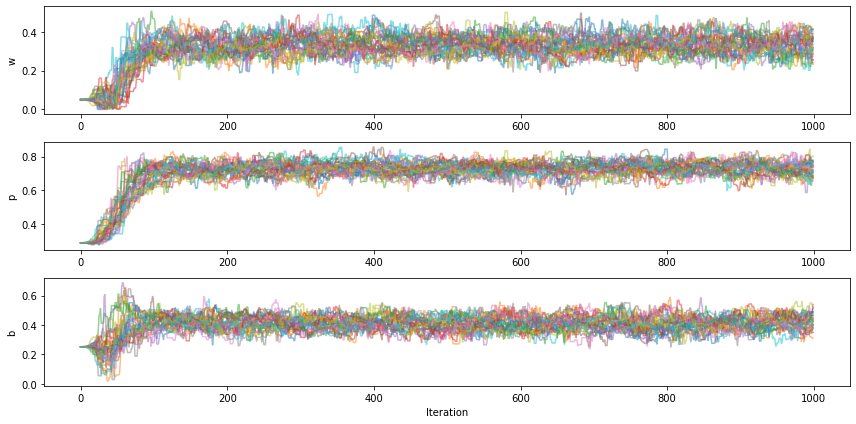

In [22]:

labels = ['w','p','b']#,'R0','κ','m','b0']
ndim = len(labels)
n_walkers = 30 # 100 walkers and 1000 iterations seem to give the best convergence of the emcee 

# Trace Plots
plt.figure(figsize=(12, 6))
for dim in range(ndim):
    plt.subplot(ndim, 1, dim + 1)
    for walker in range(n_walkers):
        plt.plot(chains[:, walker, dim], alpha=0.5)
    plt.ylabel(labels[dim])
plt.xlabel("Iteration")
plt.tight_layout()
plt.show()
# this seems to show a burn-in of about 100 is safe

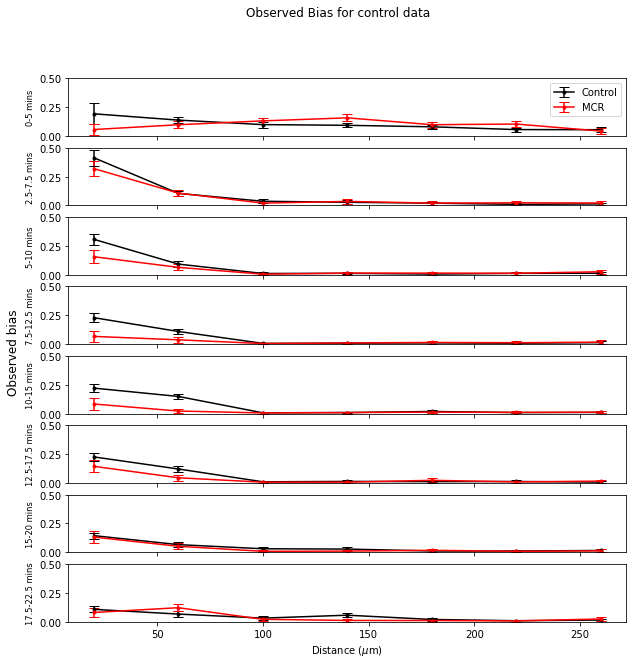

In [23]:
fig, ax = plt.subplots(len(time_labels), 1, figsize=(10, 10), sharex=True)
fig.suptitle("Observed Bias for control data")
for i in range(len(time_labels)):
    meansC = []
    stdsC = []
    meansM = []
    stdsM = []
    for j in range(len(distance)):
        ObBiasC = bias_values_control(j, i)
        ObBiasM = bias_values_mcr(j, i)

        meansC.append(ObBiasC[0])
        stdsC.append(ObBiasC[1])
        meansM.append(ObBiasM[0])
        stdsM.append(ObBiasM[1])
    ax[i].errorbar(distance,meansC,yerr = stdsC,marker='o',markersize = 3,capsize = 5,color = 'k', label = "Control")
    ax[i].errorbar(distance,meansM,yerr = stdsM,marker='o',markersize = 3,capsize = 5,color = 'r', label = "MCR")
    ax[i].set_ylim(0,0.5)
    ax[i].set_ylabel(f"{time_labels[i]} mins", rotation=90, size='small')
plt.xlabel("Distance ($\mu$m)")
ax[0].legend(loc='upper right')

fig.text(0.04, 0.5, 'Observed bias', va='center', rotation='vertical', size = 'large')
plt.savefig("Figures/Observed bias control & mcr_new_data_1.pdf")
plt.show()

In [35]:
# rearrange data to plot all time-points in one plot
obs_bias_control = []
for i in range(len(time_labels)):
    meansC = []
    stdsC = []
    for j in range(len(distance)):
        ObBiasC = bias_values_control(j, i)
        meansC.append(ObBiasC[0])
        stdsC.append(ObBiasC[1])
    obs_bias_control.append([meansC,stdsC])
np.shape(obs_bias_control) # dimensions are 8 time points, [mean, std], 7 distances

(8, 2, 7)

In [36]:
# concvert to DataFrame to save as spreadsheet
Observed_bias_control = pd.DataFrame(obs_bias_control)
Observed_bias_control.columns = ["Mean", "Stdev"]
Observed_bias_control.to_excel("Exports/Observed_bias_control.xlsx")

In [37]:
obs_bias_mcr = []
for i in range(len(time_labels)):
    meansM = []
    stdsM = []
    for j in range(len(distance)):
        ObBiasM = bias_values_mcr(j, i)
        meansM.append(ObBiasM[0])
        stdsM.append(ObBiasM[1])
    obs_bias_mcr.append([meansM,stdsM])
np.shape(obs_bias_mcr)# dimensions are 8 time points, [mean, std], 7 distances

(8, 2, 7)

In [38]:
# concvert to DataFrame to save as spreadsheet
Observed_bias_mcr = pd.DataFrame(obs_bias_mcr)
Observed_bias_mcr.columns = ["Mean", "Stdev"]
Observed_bias_mcr.to_excel("Exports/Observed_bias_mcr.xlsx")

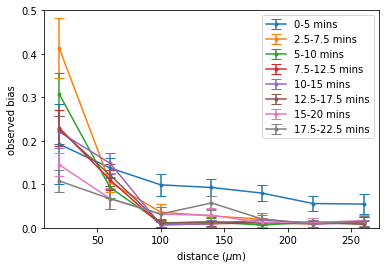

In [39]:
for i in range(8):
    plt.errorbar(distance, obs_bias_control[i][0], yerr=obs_bias_control[i][1],marker='o',markersize = 3,capsize = 5, label = f"{time_labels[i]} mins")
    
plt.legend()
plt.ylim(0,0.5)
plt.xlabel("distance ($\mu$m)")
plt.ylabel("observed bias")
plt.savefig("Figures/Observed_bias_control.pdf")

plt.show()

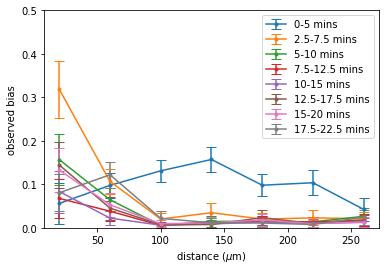

In [40]:
np.shape(obs_bias_mcr)
for i in range(8):
    plt.errorbar(distance, obs_bias_mcr[i][0], yerr=obs_bias_mcr[i][1],marker='o',markersize = 3,capsize = 5,label = f"{time_labels[i]} mins")
plt.legend()
plt.ylim(0,0.5)
plt.xlabel("distance ($\mu$m)")
plt.ylabel("observed bias")
plt.savefig("Figures/Observed_bias_mcr.pdf")
plt.show()